# О заданиях
Специалисту по машинному обучению часто приходится работать с различными API и их документацией, поэтому важно уметь эффективно с этим справляться. В качестве площадки для экспериментов и тестов выбрано API ЦБ РФ (https://cbr.ru/development/), для работы с которым не требуется регистрация и получение ключей доступа.

API ЦБ РФ позволяет получать данные в формате XML. Этот формат используется для обмена информацией между внешними источниками и системами принятия решений (СПР) банков. 

Использование GPT стало повсеместным, и можно спокойно использовать его для решения задач.

Из-за развития LLM пришлось пересмотреть задания, чтобы они не превратились в простое копирование и вставку в LLM. Поэтому задачи могут показаться несколько масштабнее, чем это было принято на собеседованиях ранее, и рассчитаны на то, что работа будет выполнена в тандеме с GPT.

В задачах соберны данные о курсах валют, ключевой ставке.

# Задание 1:
Первой задачей будет самое простое обращение, используя http://www.cbr.ru/scripts/XML_daily.asp, забрать актуальные курсы: Доллара США, Евро, фунта стерлингов и Китайского юаня. Таблица pandas dataframe должна содержать следующие столбцы: 'Date' - дата актуальности курса, которая передается в ответе XML
- `ID`
- `NumCode`
- `CharCode`
- `Nominal`
- `Name`
- `Value`
- `VunitRate`

Все эти латинские названия столбцов не очень удобны для наших будущих пользователей, но, к счастью, ЦБ за нас уже всё сделал и в XSD схеме есть как понятное описание каждого столбца, так и его тип https://cbr.ru/StaticHtml/File/92172/ValCurs.xsd Python код должен автоматически брать описание столбца из XSD схемы для наименования столбцов в pandas dataframe. (Например вместо NumCode - "ISO Цифр. код валюты" и т.д.)

In [1]:
import requests
import pandas as pd
import xml.etree.ElementTree as ET

In [2]:
# URL для получения курсов валют
url = "http://www.cbr.ru/scripts/XML_daily.asp"

In [3]:
# Запрос на получение XML данных
response = requests.get(url)
xml_content = response.content

# Парсинг XML данных
root = ET.fromstring(xml_content)

# Список нужных валют
required_currencies = ["USD", "EUR", "GBP", "CNY"]

In [4]:
# Функция для получения данных из XML
def get_currency_data(root, required_currencies):
    data = []
    date = root.attrib["Date"]
    for valute in root.findall('Valute'):
        char_code = valute.find('CharCode').text
        if char_code in required_currencies:
            currency_data = {
                "Date": date,
                "ID": valute.attrib["ID"],
                "NumCode": valute.find('NumCode').text,
                "CharCode": char_code,
                "Nominal": int(valute.find('Nominal').text.replace(',', '')),
                "Name": valute.find('Name').text,
                "Value": float(valute.find('Value').text.replace(',', '.'))
            }
            currency_data["VunitRate"] = currency_data["Value"] / currency_data["Nominal"]
            data.append(currency_data)
    return data

In [5]:
# Получаем данные по нужным валютам
currency_data = get_currency_data(root, required_currencies)

# Создание DataFrame
df = pd.DataFrame(currency_data)

In [6]:
# Загрузка и парсинг XSD для получения описаний столбцов
xsd_url = "https://cbr.ru/StaticHtml/File/92172/ValCurs.xsd"
xsd_response = requests.get(xsd_url)
xsd_root = ET.fromstring(xsd_response.content)

In [7]:
# Функция для получения описаний столбцов из XSD
def get_column_descriptions(xsd_root):
    descriptions = {}
    for element in xsd_root.findall(".//xs:element", namespaces={'xs': 'http://www.w3.org/2001/XMLSchema'}):
        name = element.attrib["name"]
        annotation = element.find(".//xs:documentation", namespaces={'xs': 'http://www.w3.org/2001/XMLSchema'})
        if annotation is not None:
            descriptions[name] = annotation.text
    return descriptions

In [8]:
# Получаем описания столбцов
column_descriptions = get_column_descriptions(xsd_root)

In [9]:
# Переименование столбцов в DataFrame
df.rename(columns={
    "Date": "Дата актуальности курса",
    "ID": column_descriptions["Valute"],
    "NumCode": column_descriptions["NumCode"],
    "CharCode": column_descriptions["CharCode"],
    "Nominal": column_descriptions["Nominal"],
    "Name": column_descriptions["Name"],
    "Value": column_descriptions["Value"],
    "VunitRate": "Стоимость единицы валюты"
}, inplace=True)

In [10]:
# Вывод DataFrame
df

,Дата актуальности курса,ISO Цифр. код валюты,ISO Цифр. код валюты,ISO Букв. код валюты,номинал. ед,Название валюты,Значение,Стоимость единицы валюты
0,30.07.2024,R01035,826,GBP,1,Фунт стерлингов Соединенного королевства,111.2497,111.2497
1,30.07.2024,R01235,840,USD,1,Доллар США,86.5554,86.5554
2,30.07.2024,R01239,978,EUR,1,Евро,94.1381,94.1381
3,30.07.2024,R01375,156,CNY,1,Китайский юань,11.8567,11.8567


# Задание 2:
Некоторые данные с сайта ЦБ получить немного сложнее, и в запросах используется SOAP.

Получите данные о ключевой ставке ЦБ РФ с 1 января 2023 года по 30 июня 2024 года и постройте график изменения ключевой ставки.

https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?op=KeyRate

In [11]:
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.parser import parse

In [12]:
# Полная ссылка для SOAP-запроса
url = "https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?op=KeyRate"

# SOAP-запрос
soap_request = """<?xml version="1.0" encoding="utf-8"?>
<soap:Envelope xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/" xmlns:web="http://web.cbr.ru/">
  <soap:Body>
    <web:KeyRate>
      <web:fromDate>2023-01-01</web:fromDate>
      <web:ToDate>2024-06-30</web:ToDate>
    </web:KeyRate>
  </soap:Body>
</soap:Envelope>"""

# Заголовки для SOAP-запроса
headers = {
    "Content-Type": "text/xml; charset=utf-8",
    "SOAPAction": "http://web.cbr.ru/KeyRate"
}

In [13]:
# Отправка SOAP-запроса
response = requests.post(url, data=soap_request, headers=headers)

# Парсинг XML-ответа
root = ET.fromstring(response.content)

# Неймспейсы для парсинга
namespaces = {
    "soap": "http://schemas.xmlsoap.org/soap/envelope/",
    "m": "http://web.cbr.ru/",
    "diffgr": "urn:schemas-microsoft-com:xml-diffgram-v1"
}

In [14]:
# Извлечение данных о ключевой ставке
key_rates = []
for record in root.findall(".//diffgr:diffgram//KeyRate//KR", namespaces):
    date = record.find("DT").text
    value = record.find("Rate").text
    key_rates.append({
        "Date": parse(date), 
        "Value": float(value.replace(',', '.'))
    })

# Создание DataFrame
df = pd.DataFrame(key_rates)

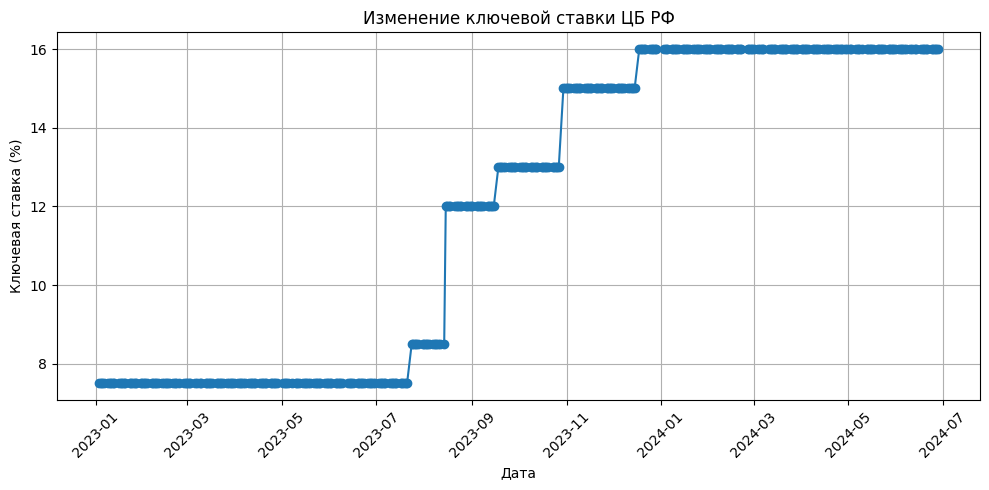

In [15]:
# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(df["Date"], df["Value"], marker='o')
plt.title("Изменение ключевой ставки ЦБ РФ")
plt.xlabel("Дата")
plt.ylabel("Ключевая ставка (%)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Задание 3:
У нас уже есть ключевая ставка, давайте посмотрим, связаны ли динамики ставок межбанковского рынка и ключевая ставка. 

Необходимо выгрузить данные по межбанковским ставкам с 1 января 2023 года по 30 июня 2024 года и построить график изменения ключевой ставки и межбанковских ставок на одном графике.

Так как аналитику чаще требуется самостоятельно найти, где искать данные, то нужно самостоятельно найти API для получения данных по межбанковским ставкам, а также XSD с описанием полей.

Проверить себя можно вот здесь: https://www.cbr.ru/hd_base/mkr/mkr_base/

In [16]:
# URL для отправки SOAP-запроса для межбанковских ставок
url_mkr = "https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?op=MKR"

# SOAP-запрос для межбанковских ставок
soap_request_mkr = """<?xml version="1.0" encoding="utf-8"?>
<soap:Envelope xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/" xmlns:web="http://web.cbr.ru/">
  <soap:Body>
    <web:MKR>
      <web:fromDate>2023-01-01</web:fromDate>
      <web:ToDate>2024-06-30</web:ToDate>
    </web:MKR>
  </soap:Body>
</soap:Envelope>"""

# Заголовки для SOAP-запроса
headers = {
    "Content-Type": "text/xml; charset=utf-8",
    "SOAPAction": "http://web.cbr.ru/MKR"
}

In [17]:
# Отправка SOAP-запроса
response_mkr = requests.post(url_mkr, data=soap_request_mkr, headers=headers)

# Парсинг XML-ответа
root_mkr = ET.fromstring(response_mkr.content)

# Неймспейсы для парсинга
namespaces = {
    "soap": "http://schemas.xmlsoap.org/soap/envelope/",
    "web": "http://web.cbr.ru/",
    "msdata": "urn:schemas-microsoft-com:xml-msdata",
    "diffgr": "urn:schemas-microsoft-com:xml-diffgram-v1"
}

In [18]:
# Извлечение данных о межбанковских ставках
mkr_rates = []
for record in root_mkr.findall(".//diffgr:diffgram//mkr_base//MKR", namespaces):
    date = record.find("CDate", namespaces)
    p1 = record.find("p1", namespaces)
    d1 = record.find("d1", namespaces)

    if date is not None and p1 is not None and d1 is not None:
        date = date.text
        p1 = p1.text
        d1 = d1.text

        value = float(d1.replace(',', '.'))
        mkr_rates.append({
            "Date": parse(date),
            "Type": int(p1),
            "Value": value
        })

# Создание DataFrame для межбанковских ставок
df_mkr = pd.DataFrame(mkr_rates)

In [19]:
# Выбираем необходимые типы
df_mkr = df_mkr[df_mkr['Type'].isin([3, 4, 7])]

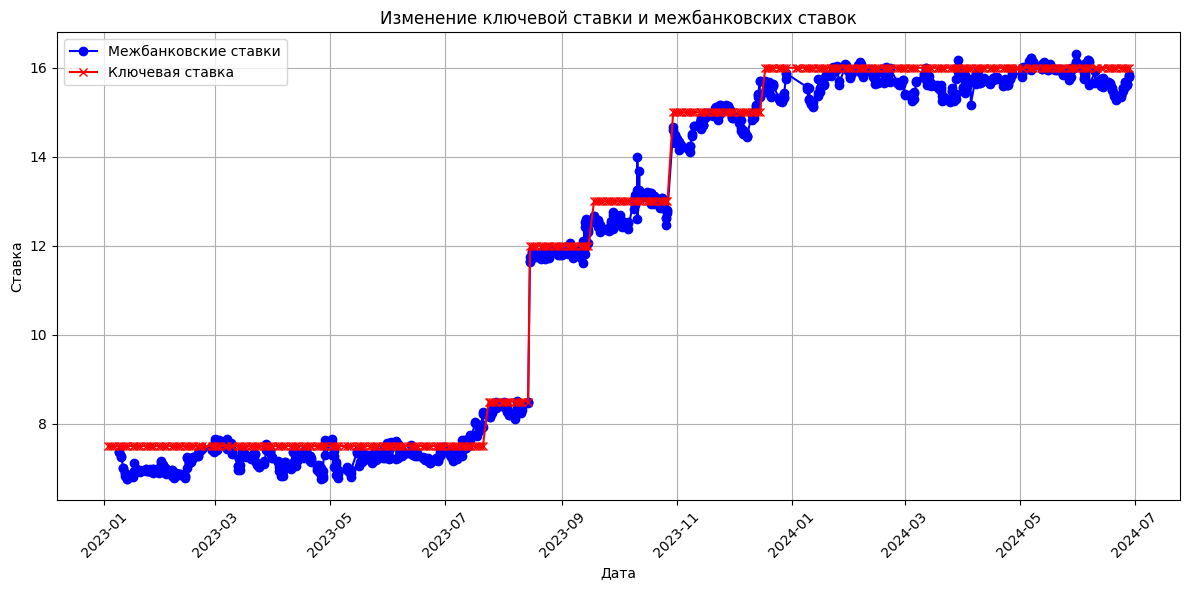

In [20]:
# Построение графика изменения ключевой ставки и межбанковских ставок
plt.figure(figsize=(12, 6))

# График межбанковских ставок
plt.plot(df_mkr["Date"], df_mkr["Value"], marker='o', linestyle='-', color='b', label="Межбанковские ставки")

# График ключевой ставки
plt.plot(df["Date"], df["Value"], marker='x', linestyle='-', color='r', label="Ключевая ставка")

plt.title("Изменение ключевой ставки и межбанковских ставок")
plt.xlabel("Дата")
plt.ylabel("Ставка")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
